In [ ]:
# prompt: clear colab storage and all uploaded files

!rm -rf /content/*

In [ ]:
#Kenneth's code
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving output-20230522-084721.flac to output-20230522-084721.flac
Saving output-20230522-084822.flac to output-20230522-084822.flac
Saving output-20230522-084923.flac to output-20230522-084923.flac
Saving output-20230522-085024.flac to output-20230522-085024.flac
Saving output-20230522-085125.flac to output-20230522-085125.flac
Saving output-20230522-085226.flac to output-20230522-085226.flac
Saving output-20230522-085327.flac to output-20230522-085327.flac
Saving output-20230522-085427.flac to output-20230522-085427.flac
Saving output-20230522-085528.flac to output-20230522-085528.flac
Saving output-20230522-085628.flac to output-20230522-085628.flac
Saving output-20230522-085729.flac to output-20230522-085729.flac
Saving output-20230522-085830.flac to output-20230522-085830.flac
Saving output-20230522-085930.flac to output-20230522-085930.flac
Saving output-20230522-090030.flac to output-20230522-090030.flac
Saving output-20230522-090130.flac to output-20230522-090130.flac
Saving out

In [ ]:
#Kenneth's code
import os
from pydub import AudioSegment

data_path = '/content/drive/MyDrive/22:05:23/'

all_files = os.listdir(data_path)


audio_files = [os.path.join(data_path, f) for f in all_files if f.lower().endswith(('.wav', '.mp3', '.flac', '.ogg'))]

audio_files.sort()

audio_files = audio_files[-20:]

if not audio_files:
    print(f"No audio files found in {data_path}")
else:
    # Read the first audio file
    combined_audio = AudioSegment.from_file(audio_files[0])

    # Concatenate the rest of the audio files
    for audio_file in audio_files[1:]:
        try:
            next_audio = AudioSegment.from_file(audio_file)
            combined_audio += next_audio
        except Exception as e:
            print(f"Could not process file {audio_file}: {e}")

    # Export the combined audio to a new file (e.g., FLAC format)
    output_filename = "combined_audio.flac"
    # Try specifying 'wav' format during export as a workaround for large files
    # This might force pydub to handle the internal data representation differently
    try:
        combined_audio.export(output_filename, format="flac")
        print(f"Concatenated audio saved to {output_filename}")
    except Exception as e:
        print(f"Error during FLAC export, attempting with 'wav' intermediate format: {e}")
        try:
            # Export to WAV first, then potentially convert if needed (though FLAC export directly should work)
            # This is more of a diagnostic step or a potential workaround if the direct FLAC export fails due to size
            combined_audio.export("temp_combined_audio.wav", format="wav")
            print("Exported to temporary WAV. You may need to convert this to FLAC separately if the error persists.")
        except Exception as inner_e:
             print(f"Failed even exporting to WAV: {inner_e}")

Concatenated audio saved to combined_audio.flac


In [ ]:
from pydub import AudioSegment

# the uploaded files are in the uploaded dictionary
# and you want to concatenate them in the order they were uploaded or a specific order

# List of file names to concatenate (replace with your actual file names)
audio_files = list(uploaded.keys()) # Example: using the keys from the uploaded dictionary

if not audio_files:
    print("No audio files uploaded.")
else:
    # Read the first audio file
    combined_audio = AudioSegment.from_file(audio_files[0])

    # Concatenate the rest of the audio files
    for audio_file in audio_files[1:]:
        next_audio = AudioSegment.from_file(audio_file)
        combined_audio += next_audio

    # Export the combined audio to a new file (e.g., WAV format)
    output_filename = "combined_audio.flac"
    combined_audio.export(output_filename, format="flac")

    print(f"Concatenated audio saved to {output_filename}")

Concatenated audio saved to combined_audio.flac


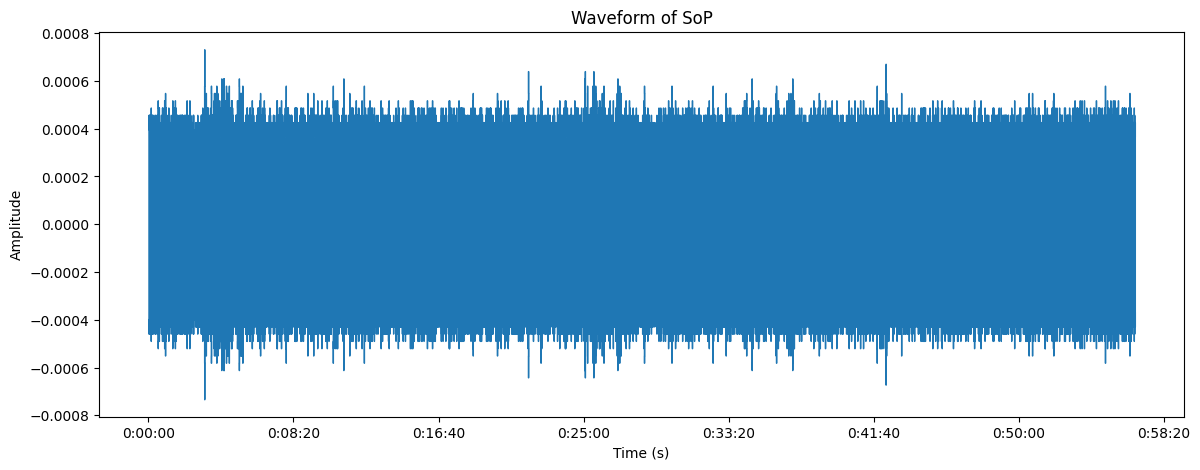

In [ ]:
import librosa
import matplotlib.pyplot as plt
import numpy as np

# Load the combined audio file
y, sr = librosa.load(output_filename, sr=44100, mono=False)

# Plot the waveform
plt.figure(figsize=(14, 5))
sop = y[0] - y[1]

librosa.display.waveshow(y[0]-y[1], sr=sr)
plt.title('Waveform of SoP')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

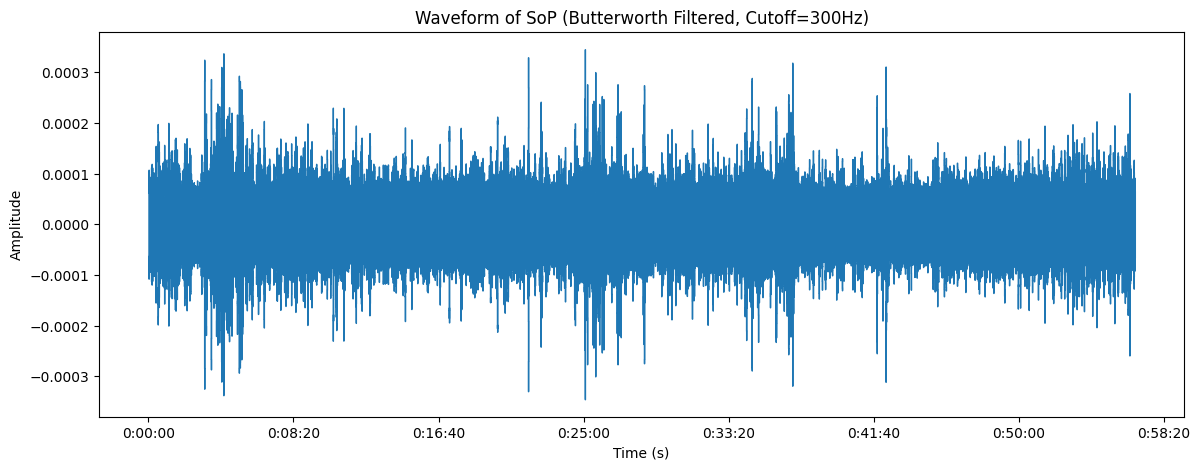

In [ ]:
# prompt: pass the sop through a butterworth filter function with cutoff frequency of 300Hz
from scipy.signal import butter, filtfilt

def butter_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Apply the Butterworth filter to the sop signal
cutoff_frequency = 300  # Hz
sop_filtered = butter_filter(sop, cutoff_frequency, sr)

# Plot the filtered waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(sop_filtered, sr=sr)
plt.title(f'Waveform of SoP (Butterworth Filtered, Cutoff={cutoff_frequency}Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()


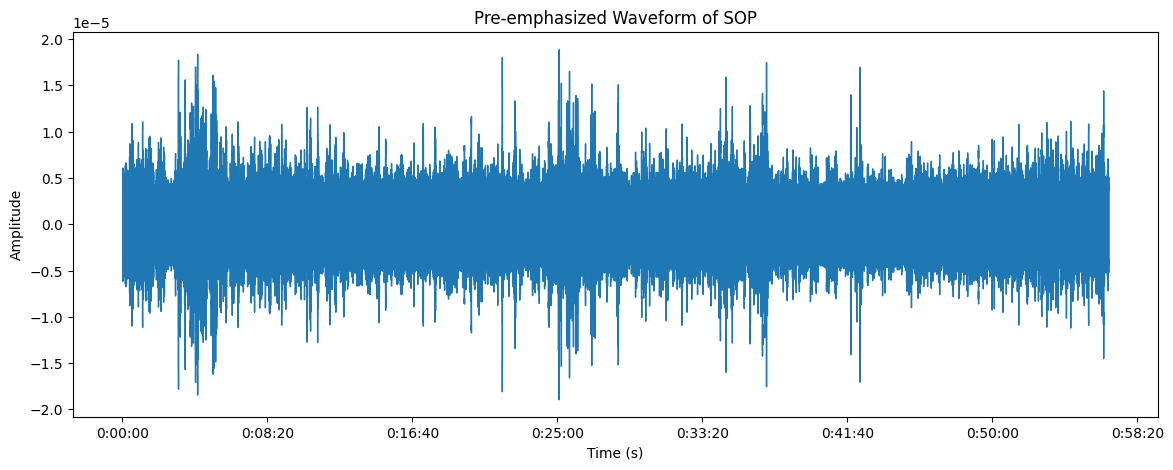

In [ ]:
from scipy.signal import lfilter
def pre_emphasize(signal, coeff=0.9459):
    return lfilter([1, -coeff], [1], signal)

pre_emphasized_sop = pre_emphasize(sop_filtered)
plt.figure(figsize=(14, 5))
librosa.display.waveshow(pre_emphasized_sop, sr=sr)
plt.title('Pre-emphasized Waveform of SOP')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

mfccs = librosa.feature.mfcc(
    y=pre_emphasized_sop,
    sr=sr,
    n_mfcc=13,
    n_fft=int(sr * 0.02),        # 20 ms window
    hop_length=int(sr * 0.01),   # 10 ms hop
    n_mels=30,
    window='hamming'
)
#drop the first coefficient
mfcc_squeezed = mfccs[1:, :]
mfccs_for_scaler_fit = mfcc_squeezed.T


In [ ]:
#Normalize the SoP
#mfccs_norm = scaler.fit_transform(mfccs_for_scaler_fit)
#Use the MinMax Normalizer for normalizing the sop
mini = np.min(mfcc_squeezed)
maxi = np.max(mfcc_squeezed)
mfccs_norm = 2 * (mfcc_squeezed - np.min(mfcc_squeezed)) / (np.max(mfcc_squeezed) - np.min(mfcc_squeezed)) - 1
print(mfccs_norm)
print(mfccs_norm.shape)

[[-0.45873931 -0.04446938 -0.0560073  ...  0.03690285 -0.45148923
  -0.46542043]
 [-0.45959996 -0.05431392 -0.06816108 ...  0.02331008 -0.45329581
  -0.4662536 ]
 [-0.46103176 -0.07049225 -0.08811657 ...  0.00098958 -0.4562762
  -0.46763968]
 ...
 [-0.4865231  -0.31871618 -0.39070053 ... -0.33792102 -0.50432844
  -0.49231707]
 [-0.49225461 -0.36471447 -0.44574458 ... -0.39970828 -0.51389772
  -0.49786556]
 [-0.49846775 -0.41077884 -0.50038491 ... -0.46110693 -0.52379304
  -0.50388031]]
(12, 340101)


(340101, 12)
Epoch [1/100], Loss: 0.0007
Epoch [2/100], Loss: 0.0000
Epoch [3/100], Loss: 0.0000
Epoch [4/100], Loss: 0.0000
Epoch [5/100], Loss: 0.0000
Epoch [6/100], Loss: 0.0000
Epoch [7/100], Loss: 0.0000
Epoch [8/100], Loss: 0.0000
Epoch [9/100], Loss: 0.0000
Epoch [10/100], Loss: 0.0000
Epoch [11/100], Loss: 0.0000
Epoch [12/100], Loss: 0.0000
Epoch [13/100], Loss: 0.0000
Epoch [14/100], Loss: 0.0000
Epoch [15/100], Loss: 0.0000
Epoch [16/100], Loss: 0.0000
Epoch [17/100], Loss: 0.0000
Epoch [18/100], Loss: 0.0000
Epoch [19/100], Loss: 0.0000
Epoch [20/100], Loss: 0.0000
Epoch [21/100], Loss: 0.0000
Epoch [22/100], Loss: 0.0000
Epoch [23/100], Loss: 0.0000
Epoch [24/100], Loss: 0.0000
Epoch [25/100], Loss: 0.0000
Epoch [26/100], Loss: 0.0000
Epoch [27/100], Loss: 0.0000
Epoch [28/100], Loss: 0.0000
Epoch [29/100], Loss: 0.0000
Epoch [30/100], Loss: 0.0000
Epoch [31/100], Loss: 0.0000
Epoch [32/100], Loss: 0.0000
Epoch [33/100], Loss: 0.0000
Epoch [34/100], Loss: 0.0000
Epoch [35/

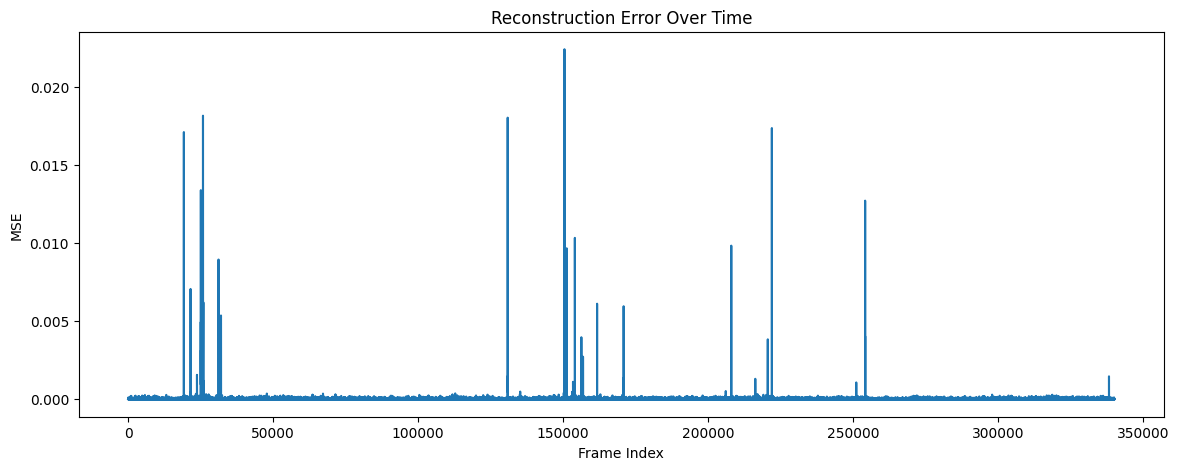

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


# Convert the NumPy array to a PyTorch Tensor
# Transpose the mfccs_norm array to have shape (number_of_frames, number_of_mfccs)
mfccs_tensor = torch.FloatTensor(mfccs_norm.T)

class MFCCDataset(Dataset):
    def __init__(self, mfccs_tensor):
        self.mfccs = mfccs_tensor

    def __len__(self):
        return len(self.mfccs)

    def __getitem__(self, idx):
        return self.mfccs[idx]

# Create the dataset and dataloader
dataset = MFCCDataset(mfccs_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

class Encoder(nn.Module):
    def __init__(self, input_dim=13, latent_dim=64):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x) # Latent space, no activation
        return x

class Decoder(nn.Module):
    def __init__(self, latent_dim=32, output_dim=13):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x) # Output layer, linear activation
        return x

class Autoencoder(nn.Module):
    def __init__(self, input_dim=13, latent_dim=32):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_dim=input_dim, latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim, output_dim=input_dim)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Define hyperparameters
input_dim = 12
latent_dim = 16
learning_rate = 0.001
num_epochs = 100
patience = 10 # For early stopping

# Initialize the autoencoder, loss function, and optimizer
model = Autoencoder(input_dim=input_dim, latent_dim=latent_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Training loop with early stopping
best_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data in dataloader:
        inputs = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    # Early stopping check
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_autoencoder.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print('Early stopping!')
            break

print('Finished Training')

# Load the best model for evaluation and anomaly detection
model.load_state_dict(torch.load('best_autoencoder.pth'))
model.eval()

# Function to compute reconstruction error for anomaly detection
def compute_reconstruction_error(model, mfccs):
    mfccs_tensor = torch.FloatTensor(mfccs.T) # Ensure correct shape (frames, mfccs)
    with torch.no_grad():
        reconstructed_mfccs = model(mfccs_tensor)
        mse = torch.mean((mfccs_tensor - reconstructed_mfccs)**2, dim=1)
    return mse.numpy()

# Example usage for anomaly detection:
# Assuming you have new MFCC data in a variable called 'new_mfccs'
# new_mfccs should have the same structure as mfccs_norm (e.g., output from librosa)

# For demonstration, let's use the training data to show the reconstruction error
reconstruction_errors = compute_reconstruction_error(model, mfccs_norm)

# Visualize the reconstruction errors over time
plt.figure(figsize=(14, 5))
plt.plot(reconstruction_errors)
plt.title('Reconstruction Error Over Time')
plt.xlabel('Frame Index')
plt.ylabel('MSE')
plt.show()

# You can set a threshold based on the distribution of reconstruction errors
# during training to classify frames as anomalous.
# For example:
# threshold = np.mean(reconstruction_errors) + 2 * np.std(reconstruction_errors)
# anomalous_frames = np.where(reconstruction_errors > threshold)[0]
# print(f"Anomalous frames: {anomalous_frames}")


In [ ]:
data_test = '/content/drive/MyDrive/Fibre_shaking/'

all_files = os.listdir(data_test)


audio_files_test = [os.path.join(data_test, f) for f in all_files if f.lower().endswith(('.flac'))]

In [ ]:
 uploaded = files.upload()

Saving output-1.flac to output-1.flac
Saving output-2.flac to output-2.flac
Saving output-3.flac to output-3.flac
Saving output-4.flac to output-4.flac
Saving output-5.flac to output-5.flac
Saving output-6.flac to output-6.flac


In [ ]:
# prompt: Delete these two files

# List of files to delete
files_to_delete = ['output-1.flac', 'output-6.flac']

for file_path in files_to_delete:
  try:
    !rm -f {file_path}
    print(f"Deleted {file_path}")
  except Exception as e:
    print(f"Error deleting {file_path}: {e}")


Deleted combined_audio.flac
Deleted best_autoencoder.pth


In [ ]:
audio_files = list(uploaded.keys())
print(audio_files)

['output-1.flac', 'output-2.flac', 'output-3.flac', 'output-4.flac', 'output-5.flac', 'output-6.flac']


In [ ]:
# Function to compute reconstruction error for anomaly detection
def compute_reconstruction_error(model, mfccs):
    # mfccs is expected to have shape (frames, mfccs)
    # Convert the NumPy array to a PyTorch Tensor
    mfccs_tensor = torch.FloatTensor(mfccs) # Remove .T transpose here
    with torch.no_grad():
        reconstructed_mfccs = model(mfccs_tensor)
        mse = torch.mean((mfccs_tensor - reconstructed_mfccs)**2, dim=1)
    return mse.numpy()

# Example usage for anomaly detection:
# Assuming you have new MFCC data in a variable called 'new_mfccs'
# new_mfccs should have the same structure as mfccs_norm (e.g., output from librosa)

# For demonstration, let's use the training data to show the reconstruction error
reconstruction_errors = compute_reconstruction_error(model, mfccs_new_norm)

# Visualize the reconstruction errors over time
plt.figure(figsize=(14, 5))
plt.plot(reconstruction_errors)
plt.title('Reconstruction Error Over Time')
plt.xlabel('Frame Index')
plt.ylabel('MSE')
plt.show()

NameError: name 'mfccs_new_norm' is not defined

In [ ]:
#audio_files = list(uploaded.keys())

new_audio_file = audio_files_test[1]


# Load the new audio file
y_new, sr_new = librosa.load(new_audio_file, sr=44100, mono=False)
sop_new = y_new[0] - y_new[1]

# Pre-emphasize the new audio
pre_emphasized_sop_new = pre_emphasize(sop_new)

# Extract MFCCs from the new audio
mfccs_new = librosa.feature.mfcc(
        y=pre_emphasized_sop_new,
        sr=sr_new,
        n_mfcc=13,
        n_fft=int(sr_new * 0.02),        # 20 ms window
        hop_length=int(sr_new * 0.01),   # 10 ms hop
        window='hamming'
)

# Apply the same normalization formula to the new MFCCs
mfccs_new_transposed = mfccs_new[1:, :].T
mfccs_new_norm = scaler.transform(mfccs_new_transposed)


print("MFCCs extracted and normalized from the new audio clip:")
print(mfccs_new_norm)
print(mfccs_new_norm.shape)

'''
# You can now use mfccs_new_norm with the trained autoencoder for anomaly detection
# For example:
reconstruction_errors_new = compute_reconstruction_error(model, mfccs_new_norm)
plt.figure(figsize=(14, 5))
plt.plot(reconstruction_errors_new)
plt.title('Reconstruction Error for New Audio')
plt.xlabel('Frame Index')
plt.ylabel('MSE')
plt.show()
'''

MFCCs extracted and normalized from the new audio clip:
[[-19.3772527   -4.85570634  -3.0962196  ...  -1.3366085    0.75190719
   -2.53081733]
 [-24.22894521   0.18279033   3.52453009 ...  -5.10510285  -1.37951309
    2.7954118 ]
 [-18.0261975   -1.16088342   0.35342006 ...  -0.32885536  -1.75815379
   -2.43346611]
 ...
 [-23.90682658  -5.11492091  -0.63008542 ...  -1.27982989   1.87019192
    3.89370086]
 [-20.59446508   2.90016197   2.90640541 ...   4.60905384   4.66968077
    2.97644664]
 [-21.76026573   0.41217545  -2.32397399 ...   3.44758461  -1.47289589
   -4.29250419]]
(6101, 12)


"\n# You can now use mfccs_new_norm with the trained autoencoder for anomaly detection\n# For example:\nreconstruction_errors_new = compute_reconstruction_error(model, mfccs_new_norm)\nplt.figure(figsize=(14, 5))\nplt.plot(reconstruction_errors_new)\nplt.title('Reconstruction Error for New Audio')\nplt.xlabel('Frame Index')\nplt.ylabel('MSE')\nplt.show()\n"

In [ ]:
# prompt: convert the code in the immediate past cell into a function. the plotting functionality should not be included, but made into a separate function using the first function's output. also, the plotting function should plot the actual audio waveform with the portions of the waveform with reconstruction error above the predetermined threshold being a different color from those below it. Also, if a point in overlapping frames is considered both normal and faulty, tag as faulty

import matplotlib.pyplot as plt
import numpy as np
def process_audio_for_anomaly_detection(audio_path, mini, maxi, sr=44100, n_mfcc=13, n_fft_ms=20, hop_length_ms=10, pre_emphasis_coeff=0.9459):
  """
    Processes an audio file to extract and normalize MFCCs for anomaly detection.

    Args:
        audio_path (str): Path to the audio file.
        sr (int): Target sampling rate.
        n_mfcc (int): Number of MFCCs to extract.
        n_fft_ms (int): Window size for FFT in milliseconds.
        hop_length_ms (int): Hop length for FFT in milliseconds.
        pre_emphasis_coeff (float): Coefficient for pre-emphasis filter.

    Returns:
        tuple: A tuple containing:
            - mfccs_norm (np.ndarray): Normalized MFCCs with shape (n_mfcc, num_frames).
            - y (np.ndarray): The loaded audio waveform.
            - sr (int): The actual sampling rate of the loaded audio.
            - frame_length (int): The number of audio samples in a frame.
            - hop_length (int): The number of audio samples in a hop.
    """
  y, sr = librosa.load(audio_path, sr=sr, mono=False)
  # Assuming Stereo, taking difference
  if y.ndim > 1 and y.shape[0] == 2:
    sop = y[0] - y[1]
  else:
    sop = y # Handle mono files
  #pass the audio through the filter function
  sop_filtered = butter_filter(sop, 300, sr)
  # Pre-emphasize the audio
  def pre_emphasize(signal, coeff=pre_emphasis_coeff):
    return lfilter([1, -coeff], [1], signal)

  pre_emphasized_sop = pre_emphasize(sop_filtered)

  # Calculate frame and hop lengths in samples
  frame_length = int(sr * n_fft_ms / 1000)
  hop_length = int(sr * hop_length_ms / 1000)

  # Extract MFCCs
  mfccs = librosa.feature.mfcc(
      y=pre_emphasized_sop,
      sr=sr,
      n_mfcc=n_mfcc,
      n_fft=frame_length,
      hop_length=hop_length,
      n_mels=30,
      window='hamming'
  )
  mfcc_squeezed = mfccs[1:, :]
  #Normalize the SoP
  mfccs_norm = 2 * (mfcc_squeezed - mini) / (maxi - mini) - 1
  # Normalize the MFCCs

  return mfccs_norm.T, sop_filtered, sr, frame_length, hop_length








In [ ]:
def plot_waveform_with_anomalies(y, sr, reconstruction_errors, threshold, frame_length, hop_length):
  """
    Plots the audio waveform highlighting sections with reconstruction error above a threshold.

    Args:
        y (np.ndarray): The audio waveform.
        sr (int): The sampling rate.
        reconstruction_errors (np.ndarray): Array of reconstruction errors per frame.
        threshold (float): The threshold for classifying a frame as anomalous.
        frame_length (int): The number of audio samples in a frame.
        hop_length (int): The number of audio samples in a hop.
    """
  plt.figure(figsize=(14, 5))
  times = librosa.times_like(reconstruction_errors, sr=sr, hop_length=hop_length)

  # Determine which frames are anomalous based on the threshold
  anomalous_frames_bool = reconstruction_errors > threshold

  # Create an array to store the anomaly status for each sample
  sample_anomaly_status = np.zeros_like(y, dtype=bool)

  # Propagate frame anomaly status to samples within the frame's effective duration
  # A sample is considered anomalous if it falls within *any* frame that is marked as anomalous
  for i, is_anomalous_frame in enumerate(anomalous_frames_bool):
    if is_anomalous_frame:
      start_sample = i * hop_length
      # The end sample should cover the entire window for that frame
      end_sample = min(start_sample + frame_length, len(y))
      sample_anomaly_status[start_sample:end_sample] = True

  # Split the waveform based on anomaly status
  normal_y = y.copy()
  anomalous_y = y.copy()

  normal_y[sample_anomaly_status] = np.nan
  anomalous_y[~sample_anomaly_status] = np.nan

  # Plot the normal parts
  plt.plot(librosa.times_like(normal_y, sr=sr), normal_y, color='blue', label='Normal')

  # Plot the anomalous parts
  plt.plot(librosa.times_like(anomalous_y, sr=sr), anomalous_y, color='red', label='Anomalous')


  plt.title('Waveform with Anomalous Sections')
  plt.xlabel('Time (s)')
  plt.ylabel('Amplitude')
  plt.legend()
  plt.show()

In [ ]:
#function to plot reconstruction errors over time
def plot_reconstruction_errors(reconstruction_errors):
  plt.figure(figsize=(14, 5))
  plt.plot(reconstruction_errors)
  plt.title('Reconstruction Error Over Time')
  plt.xlabel('Frame Index')
  plt.ylabel('MSE')
  plt.show()

In [ ]:
def plot_waveform_with_anomalies_with_adaptive_thresholds(y, sr, reconstruction_errors, thresholds, frame_length, hop_length):
    """
    Plots the audio waveform highlighting sections with reconstruction error above a per-frame threshold.

    Args:
        y (np.ndarray): The audio waveform.
        sr (int): The sampling rate.
        reconstruction_errors (np.ndarray): Array of reconstruction errors per frame.
        thresholds (np.ndarray or list): Array of thresholds per frame (same length as reconstruction_errors).
        frame_length (int): The number of audio samples in a frame.
        hop_length (int): The number of audio samples in a hop.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import librosa

    plt.figure(figsize=(14, 5))
    times = librosa.times_like(reconstruction_errors, sr=sr, hop_length=hop_length)

    # Determine which frames are anomalous using per-frame thresholds
    anomalous_frames_bool = reconstruction_errors > thresholds


    # Create an array to store the anomaly status for each sample
    sample_anomaly_status = np.zeros_like(y, dtype=bool)

    # Propagate frame anomaly status to samples within the frame's effective duration
    for i, is_anomalous_frame in enumerate(anomalous_frames_bool):
        if is_anomalous_frame:
            start_sample = i * hop_length
            end_sample = min(start_sample + frame_length, len(y))
            sample_anomaly_status[start_sample:end_sample] = True

    # Split the waveform based on anomaly status
    normal_y = y.copy()
    anomalous_y = y.copy()

    normal_y[sample_anomaly_status] = np.nan
    anomalous_y[~sample_anomaly_status] = np.nan

    # Plot the normal parts
    plt.plot(librosa.times_like(normal_y, sr=sr), normal_y, color='blue', label='Normal')

    # Plot the anomalous parts
    plt.plot(librosa.times_like(anomalous_y, sr=sr), anomalous_y, color='red', label='Anomalous')

    plt.title('Waveform with Anomalous Sections (Adaptive Thresholding)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.tight_layout()
    plt.show()



In [ ]:
def plot_reconstruction_errors_with_adaptive_threshold(reconstruction_errors, thresholds):
    """
    Plots reconstruction errors as a time series, highlighting anomalies.

    Args:
        reconstruction_errors (np.ndarray): Array of reconstruction errors per frame.
        thresholds (float or np.ndarray): Scalar or array of per-frame thresholds.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    reconstruction_errors = np.array(reconstruction_errors)

    # Convert scalar threshold to array if needed
    if np.isscalar(thresholds):
        thresholds = np.full_like(reconstruction_errors, thresholds)

    # Identify anomaly locations
    is_anomalous = reconstruction_errors > thresholds
    frame_indices = np.arange(len(reconstruction_errors))

    # Split into normal and anomalous for plotting
    normal_errors = reconstruction_errors.copy()
    anomalous_errors = reconstruction_errors.copy()

    # Set opposite values to NaN for separation
    normal_errors[is_anomalous] = np.nan
    anomalous_errors[~is_anomalous] = np.nan

    # Plot full series with overlays
    plt.figure(figsize=(14, 5))
    plt.plot(frame_indices, reconstruction_errors, color='lightgray', label='Reconstruction Error')
    plt.plot(frame_indices, normal_errors, color='blue', label='Normal')
    plt.plot(frame_indices, anomalous_errors, color='red', label='Anomalous')

    # Optional: show threshold line if it's constant
    if np.all(thresholds == thresholds[0]):
        plt.axhline(y=thresholds[0], color='gray', linestyle='--', label='Threshold')

    plt.title('Reconstruction Error Over Time with Anomalies Highlighted')
    plt.xlabel('Frame Index')
    plt.ylabel('MSE')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
audio_1 = audio_files[2]
validation_mfcc, waveform_val, sr, frame_len, hop_len = process_audio_for_anomaly_detection(audio_1, mini, maxi)
reconstruction_errors_val = compute_reconstruction_error(model, validation_mfcc)


In [ ]:
print(reconstruction_errors_val.shape)
threshold = np.mean(reconstruction_errors_val) + np.std(reconstruction_errors_val)
print(threshold)

(6101,)
2.4973955


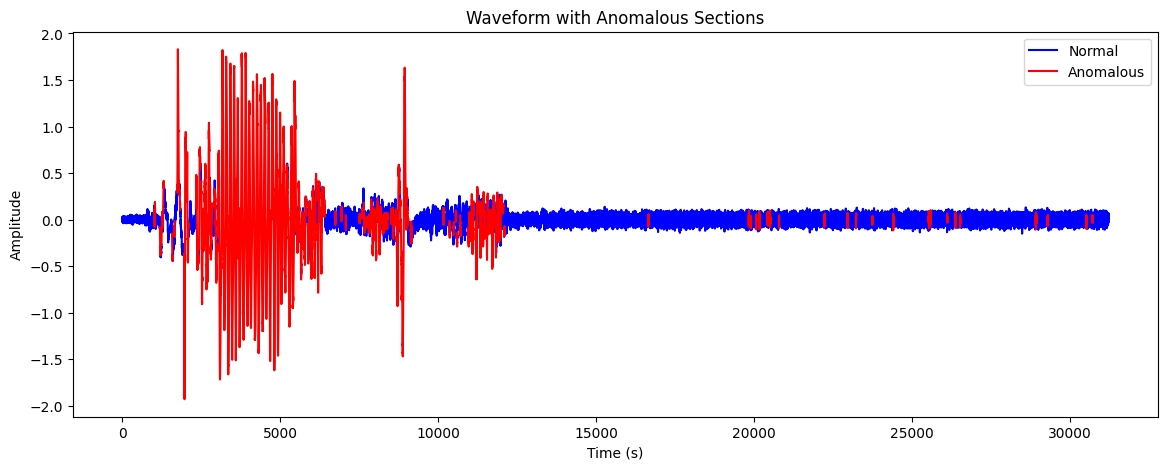

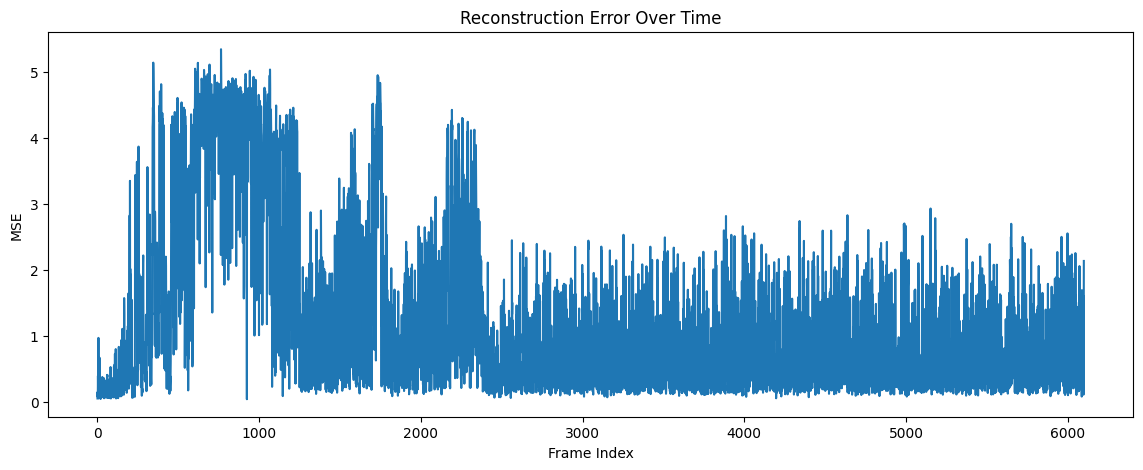

In [ ]:
plot_waveform_with_anomalies(waveform_val, sr, reconstruction_errors_val, threshold, frame_len, hop_len)
plot_reconstruction_errors(reconstruction_errors_val)

In [ ]:
import pandas as pd
reconstruction_error_series = pd.Series(reconstruction_errors_val, name='Reconstruction Error')
window = 70
k = 2
rolling_mean = reconstruction_error_series.rolling(window=window, min_periods=1).mean()
rolling_mean_list = list(rolling_mean.values)

rolling_std = reconstruction_error_series.rolling(window=window, min_periods=1).std()
rolling_std = rolling_std.fillna(0)
rolling_std_list = list(rolling_std.values)

threshold = rolling_mean + k * rolling_std
threshold_list = list(threshold.values)

#convert into lists with normal float values
float_threshold_list = [float(x) for x in threshold_list]
print(float_threshold_list)
print(len(float_threshold_list))


[0.046474020928144455, 0.2354364610485546, 0.19040625854441146, 0.4770049601929946, 0.4338285732854623, 0.4221534564137255, 0.927682009311662, 0.8707342000038385, 0.8373646261845334, 0.8008646786475764, 0.7675303705268378, 0.7921905167537152, 0.7647118393849578, 0.8218562503985907, 0.7993658395235623, 0.7776062834469806, 0.7636313991251669, 0.7449995836111107, 0.729065308013502, 0.7138270857905674, 0.6987081724801476, 0.6852625531879559, 0.6719902327850447, 0.6596430456411523, 0.6478650641486805, 0.6376515248192094, 0.6271537151562598, 0.617418368693583, 0.6079787012189213, 0.5997646351056412, 0.6041722286150489, 0.595922547478317, 0.5881208574227808, 0.5807650255490984, 0.5744284509130619, 0.5750182269399478, 0.5760172756954722, 0.5696183914974167, 0.56340063178055, 0.5578901752361383, 0.5609207372248537, 0.5556194104470675, 0.5528691647394897, 0.5516282577900917, 0.5466249084392663, 0.5477209155161601, 0.5429599135339174, 0.538319297777145, 0.5337698628846106, 0.5296253666440891, 0.5

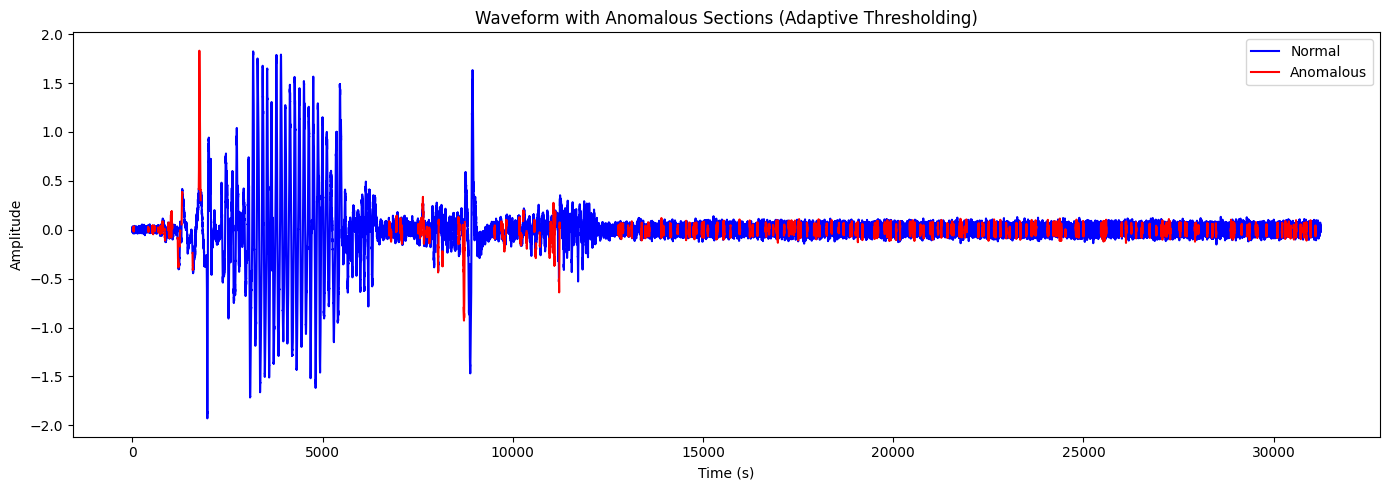

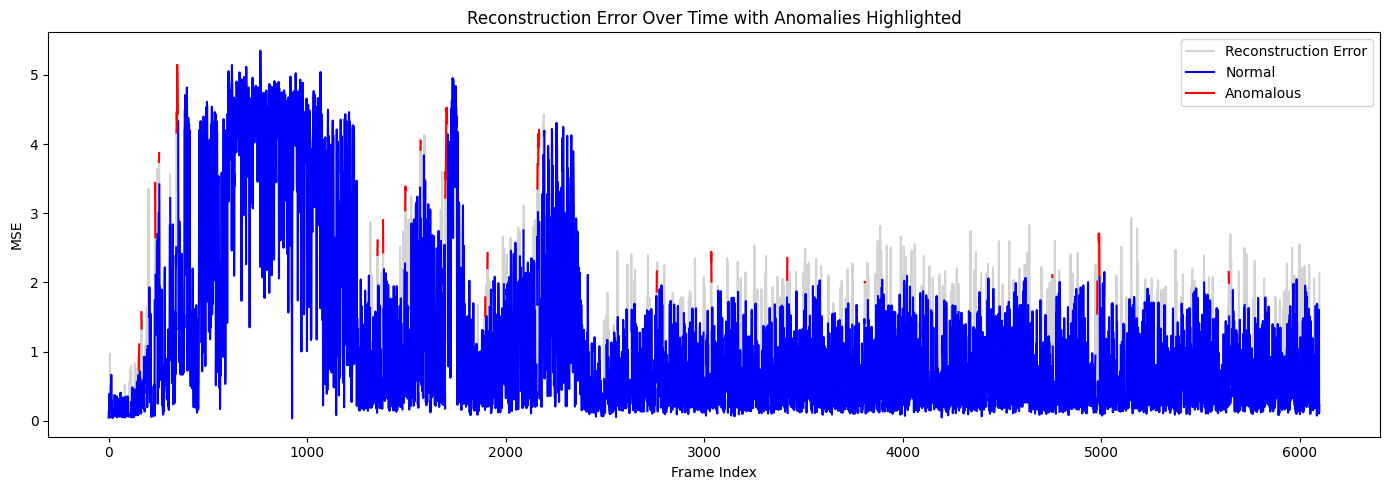

6101
6101
[False False False ... False False  True]


In [ ]:
plot_waveform_with_anomalies_with_adaptive_thresholds(waveform_val, sr, reconstruction_errors_val, float_threshold_list, frame_len, hop_len)
plot_reconstruction_errors_with_adaptive_threshold(reconstruction_errors_val, float_threshold_list)
print(len(float_threshold_list))
print(len(reconstruction_errors_val))
print(reconstruction_errors_val > float_threshold_list)

In [ ]:
from sklearn.cluster import KMeans
def cluster_reconstruction_errors(reconstruction_errors):
  """
    Clusters reconstruction errors into normal and anomalous using KMeans (2 clusters).
    Returns anomaly labels (1 for anomaly, 0 for normal).
  """
  errors = np.array(reconstruction_errors).reshape(-1, 1)

  kmeans = KMeans(n_clusters=2, random_state=0, n_init='auto')
  labels = kmeans.fit_predict(errors)

  cluster_means = [errors[labels == i].mean() for i in range(2)]
  anomaly_label = int(np.argmax(cluster_means))  # Cluster with higher mean

  is_anomaly = (labels == anomaly_label)
  return is_anomaly



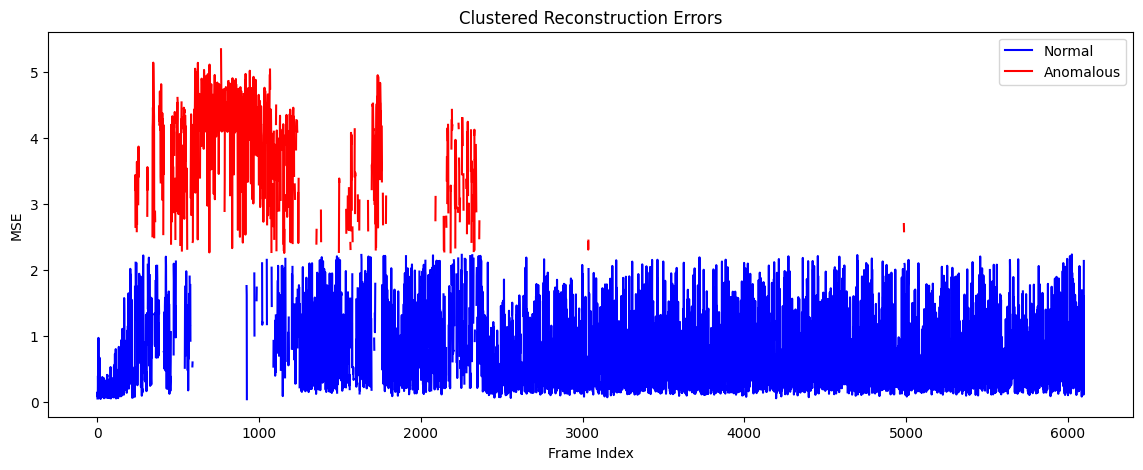

In [ ]:
# prompt: cluster and plot the reconstruction errors

import matplotlib.pyplot as plt
import numpy as np
def plot_clustered_reconstruction_errors(reconstruction_errors, anomaly_labels):
    """
    Plots reconstruction errors and highlights clustered anomalies.
    """
    plt.figure(figsize=(14, 5))
    frame_indices = np.arange(len(reconstruction_errors))

    normal_errors = reconstruction_errors.copy()
    normal_errors[anomaly_labels] = np.nan

    anomalous_errors = reconstruction_errors.copy()
    anomalous_errors[~anomaly_labels] = np.nan

    plt.plot(frame_indices, normal_errors, color='blue', label='Normal')
    plt.plot(frame_indices, anomalous_errors, color='red', label='Anomalous')

    plt.title('Clustered Reconstruction Errors')
    plt.xlabel('Frame Index')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()

# Assuming reconstruction_errors_val is available from the previous code execution
# Cluster the reconstruction errors
anomaly_labels_kmeans = cluster_reconstruction_errors(reconstruction_errors_val)

# Plot the clustered reconstruction errors
plot_clustered_reconstruction_errors(reconstruction_errors_val, anomaly_labels_kmeans)

In [ ]:
def plot_waveform_with_anomalies_from_clustering(y, sr, reconstruction_errors, thresholds, frame_length, hop_length, anomalous_frames_bool):
    """
    Plots the audio waveform highlighting sections with reconstruction error above a per-frame threshold.

    Args:
        y (np.ndarray): The audio waveform.
        sr (int): The sampling rate.
        reconstruction_errors (np.ndarray): Array of reconstruction errors per frame.
        thresholds (np.ndarray or list): Array of thresholds per frame (same length as reconstruction_errors).
        frame_length (int): The number of audio samples in a frame.
        hop_length (int): The number of audio samples in a hop.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import librosa

    plt.figure(figsize=(14, 5))
    times = librosa.times_like(reconstruction_errors, sr=sr, hop_length=hop_length)

    # Create an array to store the anomaly status for each sample
    sample_anomaly_status = np.zeros_like(y, dtype=bool)

    # Propagate frame anomaly status to samples within the frame's effective duration
    for i, is_anomalous_frame in enumerate(anomalous_frames_bool):
        if is_anomalous_frame:
            start_sample = i * hop_length
            end_sample = min(start_sample + frame_length, len(y))
            sample_anomaly_status[start_sample:end_sample] = True

    # Split the waveform based on anomaly status
    normal_y = y.copy()
    anomalous_y = y.copy()

    normal_y[sample_anomaly_status] = np.nan
    anomalous_y[~sample_anomaly_status] = np.nan

    # Plot the normal parts
    plt.plot(librosa.times_like(normal_y, sr=sr), normal_y, color='blue', label='Normal')

    # Plot the anomalous parts
    plt.plot(librosa.times_like(anomalous_y, sr=sr), anomalous_y, color='red', label='Anomalous')

    plt.title('Waveform with Anomalous Sections (Adaptive Thresholding)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.tight_layout()
    plt.show()



In [ ]:
def plot_reconstruction_errors_with_clustering(reconstruction_errors, thresholds, anomalous_frames):
    """
    Plots reconstruction errors as a time series, highlighting anomalies.

    Args:
        reconstruction_errors (np.ndarray): Array of reconstruction errors per frame.
        thresholds (float or np.ndarray): Scalar or array of per-frame thresholds.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    reconstruction_errors = np.array(reconstruction_errors)

    # Convert scalar threshold to array if needed
    if np.isscalar(thresholds):
        thresholds = np.full_like(reconstruction_errors, thresholds)

    # Identify anomaly locations
    frame_indices = np.arange(len(reconstruction_errors))

    # Split into normal and anomalous for plotting
    normal_errors = reconstruction_errors.copy()
    anomalous_errors = reconstruction_errors.copy()

    # Set opposite values to NaN for separation
    normal_errors[anomalous_frames] = np.nan
    anomalous_errors[~anomalous_frames] = np.nan

    # Plot full series with overlays
    plt.figure(figsize=(14, 5))
    plt.plot(frame_indices, reconstruction_errors, color='lightgray', label='Reconstruction Error')
    plt.plot(frame_indices, normal_errors, color='blue', label='Normal')
    plt.plot(frame_indices, anomalous_errors, color='red', label='Anomalous')

    # Optional: show threshold line if it's constant
    if np.all(thresholds == thresholds[0]):
        plt.axhline(y=thresholds[0], color='gray', linestyle='--', label='Threshold')

    plt.title('Reconstruction Error Over Time with Anomalies Highlighted')
    plt.xlabel('Frame Index')
    plt.ylabel('MSE')
    plt.legend()
    plt.tight_layout()
    plt.show()


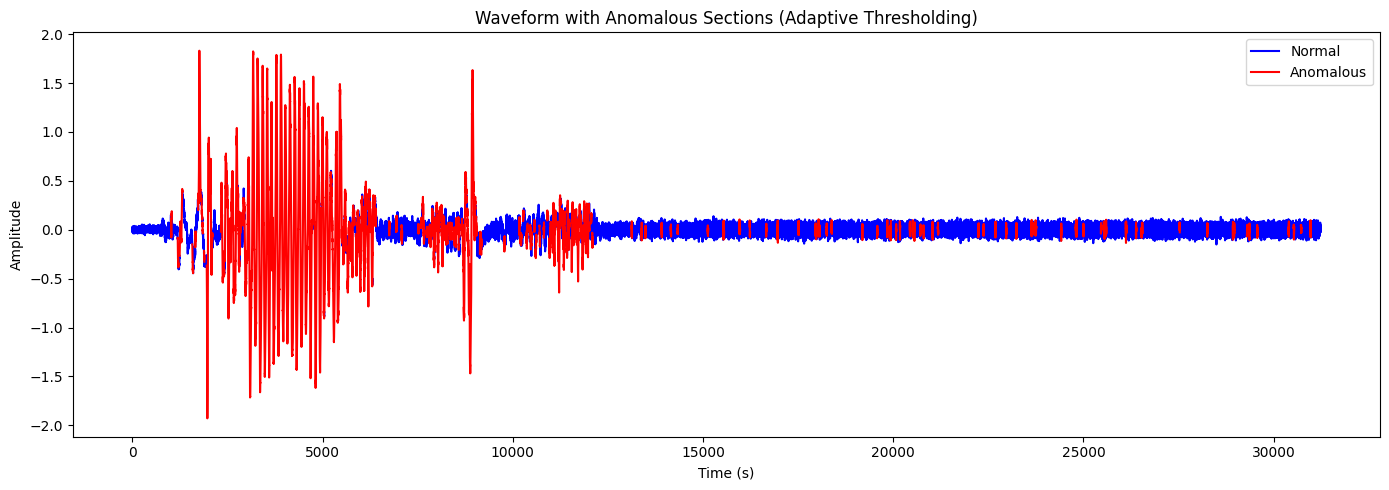

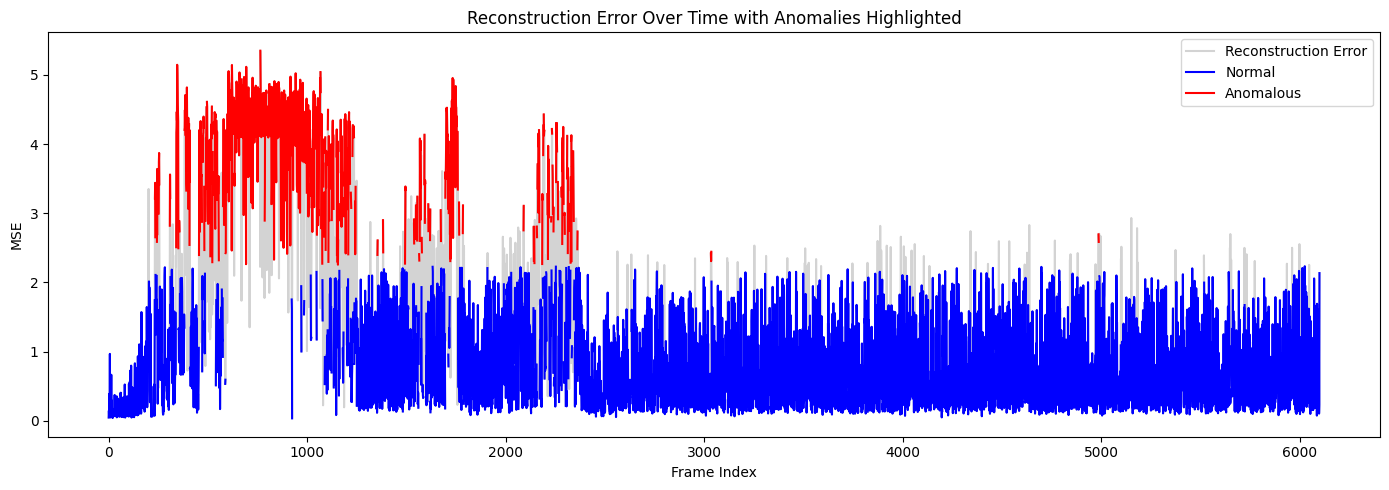

In [ ]:
plot_waveform_with_anomalies_from_clustering(waveform_val, sr, reconstruction_errors_val, float_threshold_list, frame_len, hop_len, cluster_reconstruction_errors(reconstruction_errors_val))
plot_reconstruction_errors_with_clustering(reconstruction_errors_val, float_threshold_list, cluster_reconstruction_errors(reconstruction_errors_val))

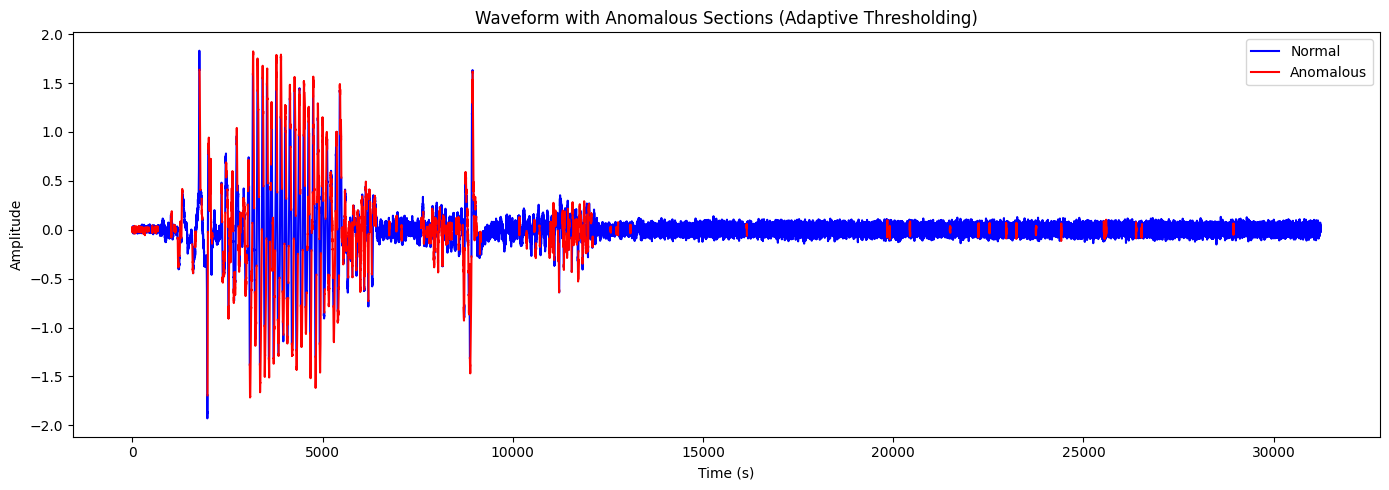

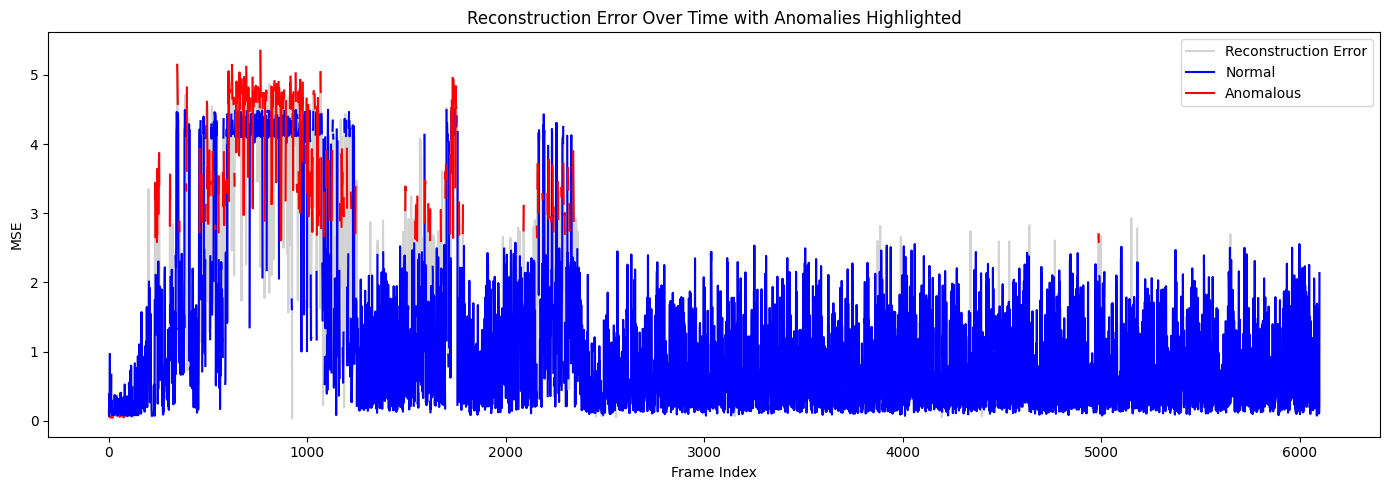

In [ ]:
#detect anomalies with isolation forest
from sklearn.ensemble import IsolationForest
def detect_anomalous_recon_errors(reconstruction_errors, contamination_rate):
  errors = reconstruction_errors.reshape(-1, 1)
  model = IsolationForest(contamination=contamination_rate)
  labels = model.fit_predict(errors)
  return labels == -1

iso_forest_labels = detect_anomalous_recon_errors(reconstruction_errors_val, 0.09)
plot_waveform_with_anomalies_from_clustering(waveform_val, sr, reconstruction_errors_val, float_threshold_list, frame_len, hop_len, iso_forest_labels)
plot_reconstruction_errors_with_clustering(reconstruction_errors_val, float_threshold_list, iso_forest_labels)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import median_abs_deviation, norm, gamma
from skimage.filters import threshold_otsu
from sklearn.mixture import GaussianMixture


def threshold_rolling_mean_std(errors, window=70, k=2):
    series = pd.Series(errors)
    rolling_mean = series.rolling(window=window, min_periods=1).mean()
    rolling_std = series.rolling(window=window, min_periods=1).std().fillna(0)
    threshold = rolling_mean + k * rolling_std
    return threshold.values


def threshold_median_mad(errors, k=3):
    med = np.median(errors)
    mad = median_abs_deviation(errors, scale='normal')  # scale=normal uses 1.4826
    threshold = med + k * mad
    return np.full_like(errors, threshold)


def threshold_quantile(errors, q=99):
    threshold = np.percentile(errors, q)
    return np.full_like(errors, threshold)


def threshold_otsu_list(errors):
    threshold = threshold_otsu(errors)
    return np.full_like(errors, threshold)


def threshold_parametric(errors, distribution='normal', q=0.997):
    if distribution == 'normal':
        mu, std = norm.fit(errors)
        threshold = norm.ppf(q, loc=mu, scale=std)
    elif distribution == 'gamma':
        shape, loc, scale = gamma.fit(errors)
        threshold = gamma.ppf(q, a=shape, loc=loc, scale=scale)
    else:
        raise ValueError("Unsupported distribution. Use 'normal' or 'gamma'.")
    return np.full_like(errors, threshold)


def threshold_gmm(errors, component=1, q=0.99):
    gmm = GaussianMixture(n_components=2, random_state=0)
    errors_reshaped = errors.reshape(-1, 1)
    gmm.fit(errors_reshaped)
    means = gmm.means_.flatten()
    variances = gmm.covariances_.flatten()

    anomaly_idx = np.argmax(means)
    mean, var = means[anomaly_idx], variances[anomaly_idx]
    std = np.sqrt(var)

    threshold = norm.ppf(q, loc=mean, scale=std)
    return np.full_like(errors, threshold)


# Example usage:
errors = reconstruction_errors_val
rolling_thresholds = threshold_rolling_mean_std(errors)
mad_thresholds = threshold_median_mad(errors)
quantile_thresholds = threshold_quantile(errors, q=99)
otsu_thresholds = threshold_otsu_list(errors)
gamma_thresholds = threshold_parametric(errors, distribution='gamma')
gmm_thresholds = threshold_gmm(errors)
